In [1]:
from nltk.tokenize import RegexpTokenizer 

# For Training
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# For dataset, and visualizing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import fasttext
import fasttext.util
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')

### Veri Okuma

In [46]:
df_dataset = pd.read_csv("../dataset/dataset.csv").drop(columns=["baslik"])

##### fasttext embeddingleri yükleme ve embedding index oluşturma

In [3]:
print('loading word embeddings...')

path = '../models/cc.tr.300.bin'
if (not os.path.exists(path)):
    fasttext.util.download_model('tr', if_exists='ignore')
    os.replace("cc.tr.300.bin", path)
    os.remove("cc.tr.300.bin.gz")

ft = fasttext.load_model(path)

embeddings_index = {}
# embedding_dim = 100
# fasttext.util.reduce_model(ft, embedding_dim)
words = ft.get_words()
for word in tqdm(words):
    embeddings_index[word] = ft.get_word_vector(word)

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


100%|██████████| 2000000/2000000 [00:25<00:00, 79050.30it/s]

found 2000000 word vectors


In [47]:
train_df, test_df = train_test_split(df_dataset, test_size=0.2, random_state=42, shuffle=True)

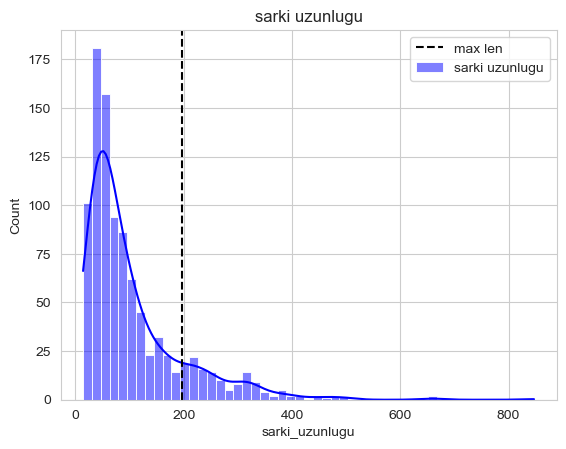

In [48]:
label_names = ["sarki_turu"]
y_train = train_df[label_names].values
train_df['sarki_uzunlugu'] = train_df['sarki_sozu'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['sarki_uzunlugu'].mean() + train_df['sarki_uzunlugu'].std()).astype(int)

sns.histplot(train_df['sarki_uzunlugu'], kde=True, color='b', label='sarki uzunlugu')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('sarki uzunlugu'); plt.legend()
plt.show()

In [49]:
processed_docs_train = train_df['sarki_sozu'].tolist()
processed_docs_test = test_df['sarki_sozu'].tolist() 
num_classes = 6

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  27167


### Shape and Train with LSTM

In [ ]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 4022


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['ilanısın' 'toprağcığını' 'acımayacan' 'elmacid' 'durmaa' 'ravza’nın'
 'mermiyim' 'mezhepdürür' 'siliyom' 'yolculuktа']


In [ ]:
# Create label encoder instance
label_encoder = LabelEncoder()

# Fit and transform labels
y_train = label_encoder.fit_transform(y_train)

c:\Users\HasanErdemAK\anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train.shape

(960,)

In [ ]:
model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))) #model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

"""model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 197, 300)          8150400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 8,606,534
Trainable params: 456,134
Non-trainable params: 8,150,400
______________________________________

"model = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))\nmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(6, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(word_seq_train, y_train, batch_size=batch_size,
          epochs=num_epochs, validation_split=0.3, shuffle=False)

Epoch 1/40
3/3 [==============================] - 17s 3s/step - loss: 1.7876 - accuracy: 0.1771 - val_loss: 1.7631 - val_accuracy: 0.3368
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 1.7496 - accuracy: 0.3289 - val_loss: 1.7127 - val_accuracy: 0.3576
Epoch 3/40
3/3 [==============================] - 7s 2s/step - loss: 1.6982 - accuracy: 0.3452 - val_loss: 1.5960 - val_accuracy: 0.3507
Epoch 4/40
3/3 [==============================] - 7s 2s/step - loss: 1.6053 - accuracy: 0.3661 - val_loss: 1.4946 - val_accuracy: 0.3472
Epoch 5/40
3/3 [==============================] - 7s 2s/step - loss: 1.5234 - accuracy: 0.3616 - val_loss: 1.4187 - val_accuracy: 0.4549
Epoch 6/40
3/3 [==============================] - 7s 2s/step - loss: 1.4230 - accuracy: 0.4167 - val_loss: 1.3990 - val_accuracy: 0.4097
Epoch 7/40
3/3 [==============================] - 7s 2s/step - loss: 1.3827 - accuracy: 0.4405 - val_loss: 1.2225 - val_accuracy: 0.5069
Epoch 8/40
3/3 [========================

0.71
0.74
0.77
0.78

In [ ]:
model.save("../models/lstm_with_fasttext")

INFO:tensorflow:Assets written to: ../models/lstm_with_fasttext\assets


In [ ]:
max(history.history["val_accuracy"])

0.7847222089767456

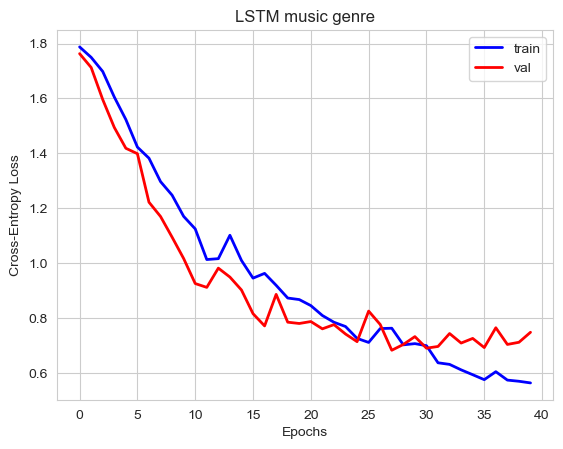

In [ ]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM music genre')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

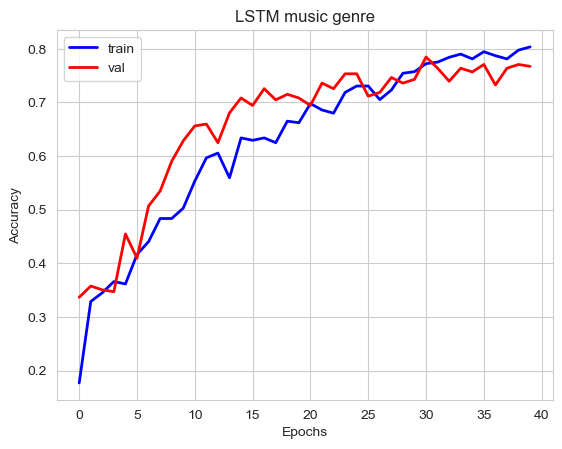

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM music genre')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
keras.backend.clear_session()

##### Submission

In [53]:
from tensorflow.keras.models import load_model

model = load_model("../models/lstm_with_fasttext")

In [57]:
test_df = pd.read_csv("../dataset/demo_dataset.csv")

processed_docs_test = test_df['sarki_sozu'].tolist() 

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_test) 
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)

#pad sequences
word_seq_test = pad_sequences(word_seq_test, maxlen=197)

predictions = model.predict(word_seq_test)
pred_labels = np.argmax(predictions, axis=1)

label_mapping = {0: "halk", 1: "ilahi", 2: "pop", 3: "rap", 4: "rock", 5: "sanat"}
converted_pred_labels = [label_mapping[x] for x in pred_labels]
print(converted_pred_labels)

tokenizing input data...
1/1 [==============================] - 0s 119ms/step
['sanat']


In [50]:
label_encoder = LabelEncoder()
y_test = test_df[label_names].values
y_test = label_encoder.fit_transform(y_test)

predictions = model.predict(word_seq_test)
pred_labels = np.argmax(predictions, axis=1)

sample = pd.DataFrame()
sample['pred']= pred_labels
sample["target"] = y_test
sample[['pred', "target"]]

import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))

label_mapping = {0: "halk", 1: "sanat", 2: "ilahi", 3: "pop", 4: "rock", 5: "rap"}
converted_pred_labels = [label_mapping[x] for x in pred_labels]
converted_y_test = [label_mapping[x] for x in y_test]

submission = pd.DataFrame()
submission["Şarkı Sözü"] = test_df["sarki_sozu"]
submission["Tahminler"] = converted_pred_labels
submission["Gerçek Değerler"] = converted_y_test
submission.to_csv("../submissions/submission.csv")

c:\Users\HasanErdemAK\anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8/8 [==============================] - 1s 155ms/step
Accuracy With fastText :
0.7666666666666667


In [ ]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [ ]:
y_test

array([3, 4, 0, 1, 0, 3, 5, 4, 1, 4, 4, 0, 0, 4, 5, 0, 1, 2, 4, 1, 5, 2,
       2, 5, 0, 5, 2, 1, 5, 1, 5, 4, 2, 2, 5, 1, 1, 0, 5, 2, 3, 0, 3, 5,
       4, 5, 5, 0, 0, 5, 2, 3, 5, 0, 3, 5, 4, 3, 3, 5, 5, 0, 5, 0, 0, 4,
       0, 1, 1, 1, 1, 0, 3, 0, 0, 1, 0, 0, 4, 4, 3, 5, 4, 0, 1, 3, 3, 0,
       3, 2, 1, 1, 5, 5, 3, 2, 1, 4, 5, 0, 1, 0, 2, 0, 4, 2, 3, 4, 3, 4,
       5, 4, 0, 4, 2, 3, 5, 0, 2, 0, 1, 4, 3, 3, 1, 3, 5, 0, 2, 2, 5, 3,
       5, 5, 3, 2, 2, 1, 1, 4, 3, 2, 5, 2, 2, 1, 2, 2, 1, 1, 3, 5, 2, 5,
       4, 1, 5, 5, 3, 5, 3, 4, 3, 5, 5, 4, 0, 4, 4, 0, 2, 4, 5, 5, 0, 1,
       0, 3, 0, 2, 2, 4, 5, 3, 5, 4, 1, 4, 1, 1, 4, 2, 0, 4, 1, 0, 0, 4,
       4, 5, 4, 4, 2, 4, 4, 5, 2, 2, 2, 3, 3, 2, 1, 4, 4, 5, 2, 5, 2, 1,
       3, 4, 3, 4, 5, 1, 2, 0, 5, 2, 5, 0, 3, 2, 4, 5, 4, 1, 3, 4])

In [ ]:
test_df

,id,sarki_sozu,sarki_turu,eski_turkce_kelime_orani,fiil_orani,sifat_orani,zarf_orani,baglac_orani,unlem_orani,soru_orani,bilinmeyen_orani
1178,1178,bu gece yine kafalar iyi peşimizde paparazi\n5...,rap,0.05,0.08,0.14,0.06,0.02,0.01,0.00,0.07
865,865,bizi tanıyan herkes bilir senle ben eskiden be...,rock,0.03,0.14,0.03,0.16,0.00,0.05,0.01,0.00
101,101,hekimoğlu derler benim aslıma\naynalı martin y...,halk,0.09,0.19,0.07,0.00,0.11,0.00,0.00,0.00
439,439,güller sümbüller\nöten bülbüller\nyanık gönüll...,ilahi,0.07,0.09,0.14,0.00,0.07,0.00,0.00,0.07
58,58,dedim gız yaşın nedir dedi başımdır\ndedim gız...,halk,0.05,0.63,0.04,0.00,0.00,0.00,0.00,0.15
...,...,...,...,...,...,...,...,...,...,...,...
382,382,üsküdara gider iken aldı da bir yağmur\nkatibi...,sanat,0.05,0.20,0.13,0.08,0.05,0.00,0.00,0.00
867,867,dünya döner bir gün daha\nyeryüzünde aşk durdu...,rock,0.16,0.20,0.03,0.15,0.05,0.00,0.00,0.03
542,542,seherde ötüşen kuşlar\nbilmem ne diyor ne diyo...,ilahi,0.14,0.27,0.10,0.14,0.01,0.00,0.00,0.03
1193,1193,talaş toz toprak her yer\nyakınlaş dünyama bas...,rap,0.08,0.13,0.13,0.03,0.03,0.00,0.00,0.11
